In [ ]:
!pip install yfinance pandas numpy matplotlib seaborn scikit-learn pyarrow --quiet

In [ ]:
#Import Libraries & Configure Visualization
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.decomposition import PCA

In [ ]:
#configure plot styles for clear visuals.
sns.set_style('whitegrid')
sns.set_context('notebook')

In [ ]:
#Configuration (Tickers, Dates, Parameters)
tickers = ["BTC-USD", "ETH-USD", "XRP-USD"]
START_DATE = "2020-01-01"
END_DATE = datetime.today().strftime("%Y-%m-%d")


In [ ]:
raw = yf.download(tickers, start=START_DATE, end=END_DATE, group_by='ticker', auto_adjust=False)
print(raw.head())

[*********************100%***********************]  3 of 3 completed

Ticker          BTC-USD                                                      \
Price              Open         High          Low        Close    Adj Close   
Date                                                                          
2020-01-01  7194.892090  7254.330566  7174.944336  7200.174316  7200.174316   
2020-01-02  7202.551270  7212.155273  6935.270020  6985.470215  6985.470215   
2020-01-03  6984.428711  7413.715332  6914.996094  7344.884277  7344.884277   
2020-01-04  7345.375488  7427.385742  7309.514160  7410.656738  7410.656738   
2020-01-05  7410.451660  7544.497070  7400.535645  7411.317383  7411.317383   

Ticker                      ETH-USD                                      \
Price            Volume        Open        High         Low       Close   
Date                                                                      
2020-01-01  18565664997  129.630661  132.835358  129.198288  130.802002   
2020-01-02  20802083465  130.820038  130.820038  126.954910  127.41

In [ ]:
adj_close = pd.DataFrame({t: raw[t]['Adj Close'] for t in tickers})
print(adj_close.head())

                BTC-USD     ETH-USD   XRP-USD
Date                                         
2020-01-01  7200.174316  130.802002  0.192667
2020-01-02  6985.470215  127.410179  0.188043
2020-01-03  7344.884277  134.171707  0.193521
2020-01-04  7410.656738  135.069366  0.194355
2020-01-05  7411.317383  136.276779  0.195537


In [ ]:
prices = adj_close.ffill().bfill()

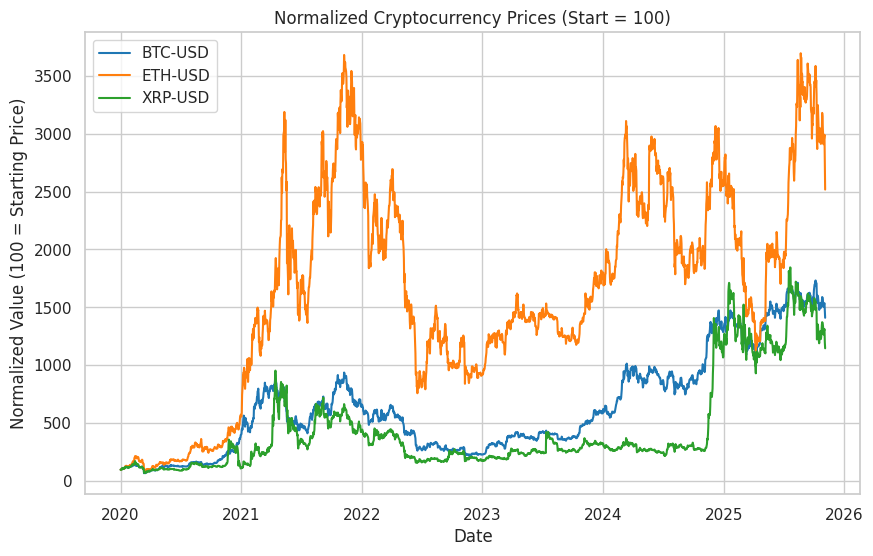

In [ ]:
#Price Trends (USD)
normalized = prices / prices.iloc[0] * 100
plt.figure(figsize=(10,6))
for t in normalized.columns:
    plt.plot(normalized.index, normalized[t], label=t)
plt.title("Normalized Cryptocurrency Prices (Start = 100)")
plt.xlabel("Date")
plt.ylabel("Normalized Value (100 = Starting Price)")
plt.legend()
plt.show()


In [ ]:
#calculate returns
daily_ret = prices.pct_change().dropna()
log_ret = np.log(prices / prices.shift(1)).dropna()

In [ ]:
#Cumulative and Normalized Prices
cumulative = (1 + daily_ret).cumprod() - 1
normalized = prices.div(prices.iloc[0]).mul(100)

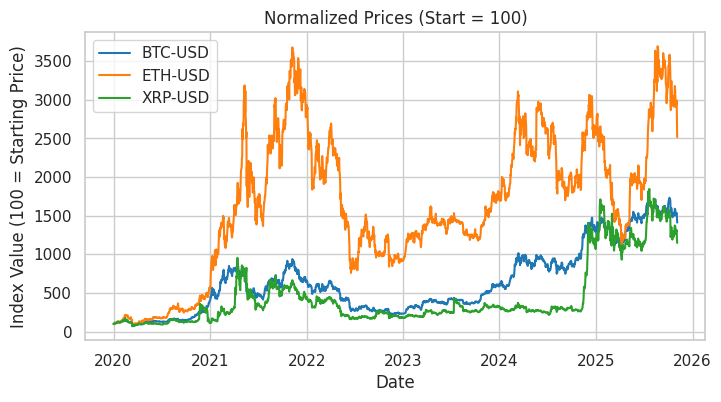

In [ ]:
#Normalized Price (Start = 100)
plt.figure(figsize=(8,4))
for t in normalized.columns:
    plt.plot(normalized.index, normalized[t], label=t)
plt.title("Normalized Prices (Start = 100)")
plt.xlabel("Date")
plt.ylabel("Index Value (100 = Starting Price)")
plt.legend()
plt.show()

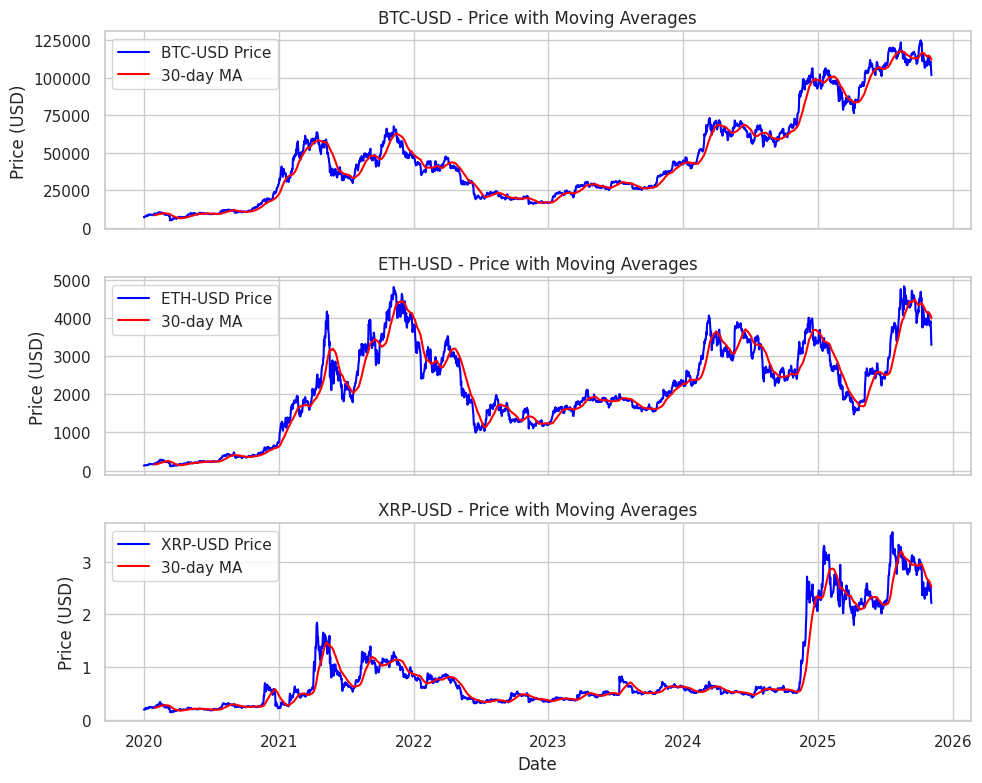

In [ ]:
#Moving Averages
tickers_to_plot = ["BTC-USD", "ETH-USD", "XRP-USD"]

fig, axes = plt.subplots(3, 1, figsize=(10,8), sharex=True)

for i, ticker in enumerate(tickers_to_plot):
    axes[i].plot(prices.index, prices[ticker], label=f"{ticker} Price", color="blue")
    axes[i].plot(ma_short.index, ma_short[ticker], label="30-day MA", color="red")
    axes[i].set_title(f"{ticker} - Price with Moving Averages")
    axes[i].set_ylabel("Price (USD)")
    axes[i].legend(loc="upper left")

plt.xlabel("Date")
plt.tight_layout()
plt.show()

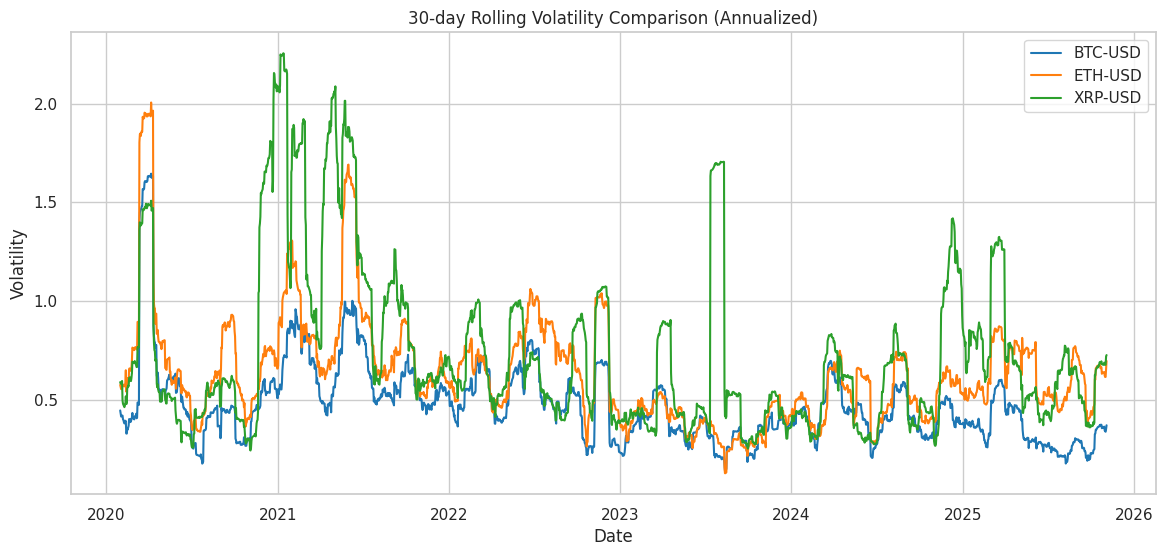

In [ ]:
#Rolling Volatility
tickers_to_plot = ["BTC-USD", "ETH-USD", "XRP-USD"]
plt.figure(figsize=(14,6))
for ticker in tickers_to_plot:
    plt.plot(rolling_vol_short.index, rolling_vol_short[ticker], label=f"{ticker}")
plt.title("30-day Rolling Volatility Comparison (Annualized)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

In [ ]:
#Maximum Drawdown Calculation
drawdowns = prices.apply(lambda x: (x - x.cummax()) / x.cummax())
max_drawdown = drawdowns.min()
print("Maximum Drawdown for each cryptocurrency:")
print(max_drawdown)


Maximum Drawdown for each cryptocurrency:
BTC-USD   -0.766346
ETH-USD   -0.793512
XRP-USD   -0.832490
dtype: float64


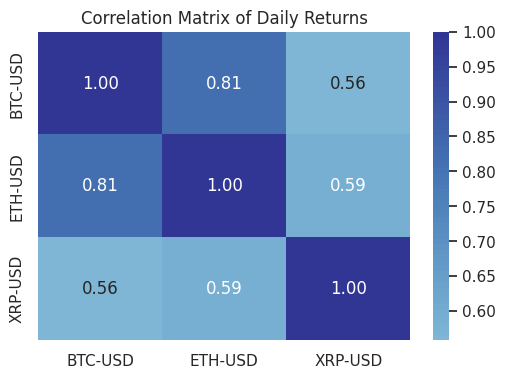

In [ ]:
#Correlation
corr_matrix = daily_ret.corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap="RdYlBu", center=0, fmt=".2f")
plt.title("Correlation Matrix of Daily Returns")
plt.show()

In [ ]:
#Risk-Return (Sharpe-like Analysis)
ann_mean_return = log_ret.mean() * 365
ann_vol = log_ret.std() * np.sqrt(365)
sharpe_like = ann_mean_return / ann_vol
risk_return = pd.DataFrame({
    "Annualized Return": ann_mean_return,
    "Annualized Volatility": ann_vol,
    "Sharpe-like": sharpe_like
}).sort_values("Sharpe-like", ascending=False)
risk_return

,Annualized Return,Annualized Volatility,Sharpe-like
BTC-USD,0.452717,0.623175,0.726468
ETH-USD,0.551732,0.832685,0.662594
XRP-USD,0.417349,1.029221,0.405500


/tmp/ipython-input-2701676660.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (risk_return["Annualized Volatility"][i], risk_return["Annualized Return"][i]),


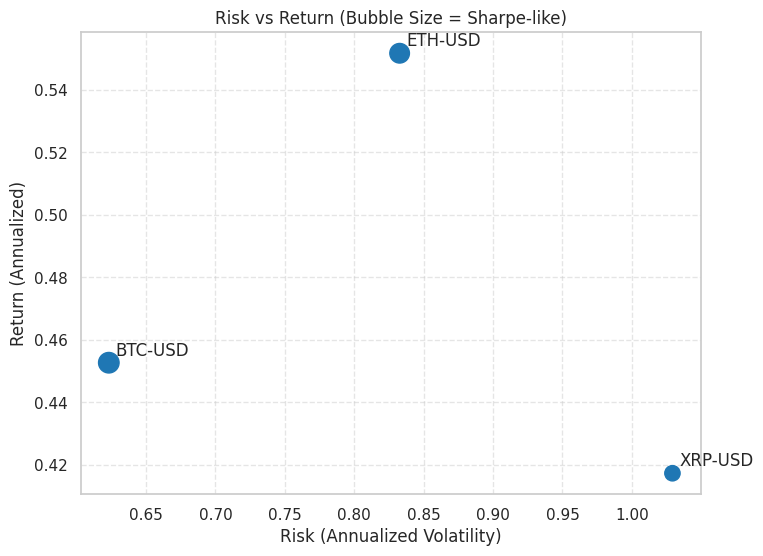

In [ ]:
#Plot Risk vs Return Scatter
plt.figure(figsize=(8,6))
plt.scatter(risk_return["Annualized Volatility"], risk_return["Annualized Return"],
            s=risk_return["Sharpe-like"]*300, alpha=1)

for i, txt in enumerate(risk_return.index):
    plt.annotate(txt, (risk_return["Annualized Volatility"][i], risk_return["Annualized Return"][i]),
                 textcoords="offset points", xytext=(5,5))

plt.title("Risk vs Return (Bubble Size = Sharpe-like)")
plt.xlabel("Risk (Annualized Volatility)")
plt.ylabel("Return (Annualized)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()
